In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import sys,os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from src.data import pretraining_pipeline, create_dataset

%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
name                 = 'macho'
lightcurves_folder   = f'./data/raw_data/{name}/LCs/' # lightcurves folder
lightcurves_metadata = f'./data/raw_data/{name}/train_meta.csv' # metadata file
fold_to_save_records = './data/records_new/'

In [4]:
meta = pd.read_csv(lightcurves_metadata)
# meta = meta[meta['Class'] != 'UNK']
# meta = meta[meta['Class'] != 'std']
# meta = meta[meta['Class'] != 'Dubious']

meta['Band'] = tf.ones(meta.shape[0])
meta = meta.rename(columns={'objID':'ID', 'Unnamed: 0':'ID', 'Path_R':'Path'})
print(meta.shape)
if 'atlas' in name:
    meta['Path'] = meta['ID'].astype(str)+'.dat'
    
print(meta['Class'].value_counts())
print(meta.shape)

2023-04-19 22:53:39.392200: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-19 22:53:39.392238: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: f24a753cc649
2023-04-19 22:53:39.392244: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: f24a753cc649
2023-04-19 22:53:39.392331: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.32.3
2023-04-19 22:53:39.392347: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.32.3
2023-04-19 22:53:39.392352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.32.3
2023-04-19 22:53:39.392624: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

(1454792, 5)
NonVar    1454792
Name: Class, dtype: int64
(1454792, 5)


## One sample visualization

In [5]:
args = {
    'alcock':{},
    'ogle': {'names':['mjd', 'mag', 'errmag'], 'delim_whitespace':True},
    'atlas': {'names':['mjd', 'mag', 'errmag'],'delim_whitespace':False, 'skiprows':1},
    'macho': {}
}

[INFO] Reading: F_1.3691.418.dat


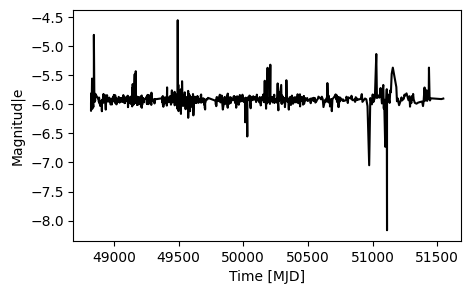

In [22]:
sample = meta.sample()['Path'].values[0].split('/')[-1]
print(f'[INFO] Reading: {sample}')
lc_sample = pd.read_csv(f'{lightcurves_folder}/{sample}', **args[name])
lc_sample.columns = ['mjd', 'mag', 'errmag']
plt.figure(figsize=(5,3))
plt.errorbar(lc_sample['mjd'], lc_sample['mag'], color='k')
plt.xlabel('Time [MJD]')
plt.ylabel('Magnitud|e')
plt.show()

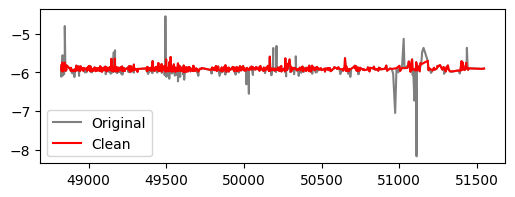

In [23]:
lc_new = lc_sample[(lc_sample['mag']>=lc_sample['mag'].quantile(.1)) &
                   (lc_sample['mag']<=lc_sample['mag'].quantile(.99)) &
                   (lc_sample['errmag']>=0.) & (lc_sample['errmag']<=1)]

plt.figure(figsize=(6, 2))
plt.plot(lc_sample['mjd'], lc_sample['mag'], color='black', alpha=0.5, label='Original')
plt.plot(lc_new['mjd'], lc_new['mag'], color='red', label='Clean')
plt.legend()

## Pretraining data

In [42]:
target = f'{fold_to_save_records}/{name}_pt'

In [43]:
meta_filtered = meta[meta['N'] > 100]
meta.shape[0], meta_filtered.shape[0]

(1454792, 1454792)

In [47]:
meta_filtered = meta_filtered.sample(frac=1)

meta_test = pd.read_csv(f'./data/raw_data/{name}/test_meta.csv') # metadata file

In [49]:
%%time
create_dataset(meta_filtered, 
               lightcurves_folder, 
               target, 
               max_lcs_per_record=20000, 
               n_jobs=16, # depends on the number of cores 
               subsets_frac=(0.8, 0.2), 
               test_subset=meta_test,
               **args[name])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [1:08:00<00:00, 4080.58s/it]


CPU times: user 43min 1s, sys: 1min 8s, total: 44min 10s
Wall time: 1h 10min 59s


### Reading pretraining data

In [20]:
n_classes = None
dataset = pretraining_pipeline(os.path.join('./data/records_new/macho_pt/', 'train'),
                               batch_size=2000, sampling=True, repeat=1,
                               msk_frac=0., rnd_frac=0., same_frac=0., 
                               num_cls=n_classes, return_ids=True)

[INFO] Repeating dataset x1 times
[INFO] Sampling random windows


In [22]:
for x, y in dataset:
    
    print(x['input'].shape)
    
    break

(2000, 200, 1)


In [16]:
%%time
n_batches = sum([1 for x in dataset])
n_batches

CPU times: user 12min 39s, sys: 2min 21s, total: 15min
Wall time: 4min 12s


582

In [30]:
def get_magnitudes(ds):
    magnitudes = []
    for x, y in ds:
        magnitudes.append(x['input'][x['input'] > 0])
    magnitudes = tf.concat(magnitudes, 0)
    return magnitudes

In [31]:
magn_train = get_magnitudes(dataset)

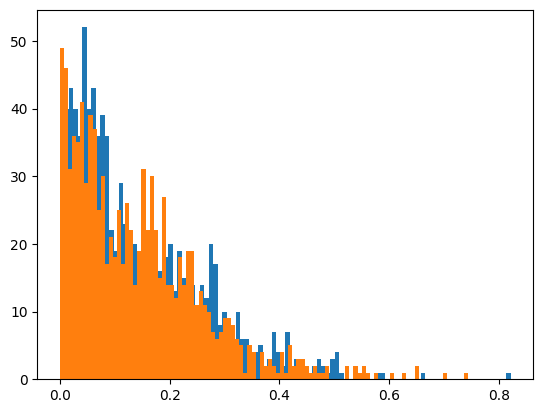

In [32]:
plt.figure()
plt.hist(magnitudes[:1000], bins=100)
plt.hist(magn_train[:1000], bins=100)
plt.show()

## Creating folds

In [6]:
n_folds = 3
samples_per_class_test = 100
samples_per_class = [20, 50, 100, 500]

In [120]:
%%time

for fold_n in range(n_folds): 
    test_meta  = pd.concat([frame.sample(n=samples_per_class_test) for g, frame in meta.groupby('Class')])
    train_meta = meta[~meta['ID'].isin(test_meta['ID'])]
    print(test_meta.shape, train_meta.shape)
        
    for nsamples in samples_per_class:  
        if nsamples == 0:
            partial_meta = train_meta
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}'
        else:
            partial_meta = pd.concat([frame.sample(n=nsamples) for c, frame in train_meta.groupby('Class')])
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}_{nsamples}'

        create_dataset(partial_meta, lightcurves_folder, 
                       target, max_lcs_per_record=20000, 
                       n_jobs=7, subsets_frac=(0.8, 0.2), test_subset=test_meta,  
                       **args[name])

(1000, 5) (357288, 5)


100%|████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


(1000, 5) (357288, 5)


100%|████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


(1000, 5) (357288, 5)


100%|████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]

CPU times: user 53.1 s, sys: 1.28 s, total: 54.4 s
Wall time: 57.7 s


# Reading folds

[INFO] Repeating dataset x1 times
(16, 200, 1)
[0 1 2 3 4]
[100 100 100 100 100]


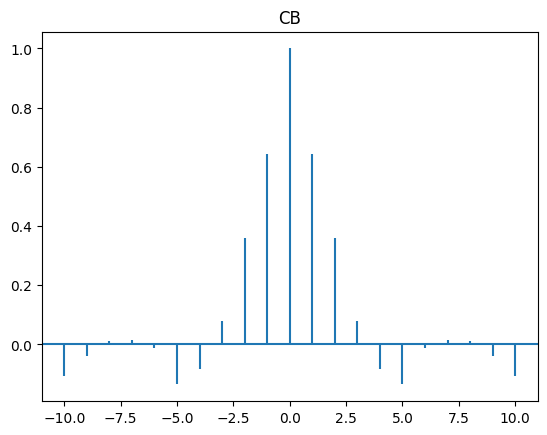

In [10]:
for fold_n in range(3):
    for nsamples in samples_per_class:
        if nsamples == 0:
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}'
        else:
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}_{nsamples}'
        
        n_classes_df = pd.read_csv(os.path.join(target, 'objects.csv'))
#         print(n_classes)
        n_classes = n_classes_df.shape[0]
        dataset = pretraining_pipeline(os.path.join(target, 'test'),
                                       window_size=200,
                                       batch_size=16,
                                       msk_frac=0., rnd_frac=0., same_frac=0., 
                                       shuffle=True,
                                       num_cls=n_classes, return_ids=True)
        classes_names = list(n_classes_df['label'].values)
        for x, y in dataset:
            print(x['input'].shape)
#             plt.plot(x['times'][0], x['input'][0])
            plt.acorr(x['input'][0][:, 0])
            plt.title(f'{classes_names[np.argmax(y[0])]}')
            break
        
        
        labels = np.concatenate([np.argmax(y, 1) for _, y in dataset], 0)
        unique, counts = np.unique(labels, return_counts=True)
        
        oids = np.concatenate([x['ids'] for x, _ in dataset], 0)
        
        unique_id, counts_id = np.unique(oids, return_counts=True)
#         print(counts_id)
        print(unique)
        print(counts)
        
        break
    break
#         print('-')